# Extensiones para Python con ctypes

Apuntes básicos sobre como llamar a funciones codificadas en C, compiladas con gcc. También, se presentan comparaciones gráficas de los tiempos de ejecución.

## Dependencias

In [1]:
import ctypes
import numpy
from numpy import linalg as LA

## Serie de Fibonacci

In [2]:
%%file c_fib.c
long long int c_fib(int n) {
    long long int tmp, a = 0, b = 1;
    for (int i=0; i<n; i++) {
        tmp = a;
        a = a + b;
        b = tmp;
    }
    return a;
}

Writing c_fib.c


In [3]:
# para generar el object file
! gcc -c -Wall -Werror  -fpic  c_fib.c

# para crear la shared library
! gcc -shared  c_fib.o -o _c_fib.so

In [4]:
def ctypes_fib():
    # ruta de la shared library
    lib = ctypes.CDLL('./_c_fib.so')
    
    # tipo de los argumentos
    lib.c_fib.argtypes = [ctypes.c_int]
    
    # tipo de la salida
    lib.c_fib.restype  = ctypes.c_longlong
    
    # se devuelve la función configurada
    return lib.c_fib

In [5]:
# instancia de la funcion
cfib = ctypes_fib()

### Prueba de Fibonacci

In [6]:
# los primeros 50 elementos de la serie de Fibonacci son
list(map(cfib,range(50)))

[0,
 1,
 1,
 2,
 3,
 5,
 8,
 13,
 21,
 34,
 55,
 89,
 144,
 233,
 377,
 610,
 987,
 1597,
 2584,
 4181,
 6765,
 10946,
 17711,
 28657,
 46368,
 75025,
 121393,
 196418,
 317811,
 514229,
 832040,
 1346269,
 2178309,
 3524578,
 5702887,
 9227465,
 14930352,
 24157817,
 39088169,
 63245986,
 102334155,
 165580141,
 267914296,
 433494437,
 701408733,
 1134903170,
 1836311903,
 2971215073,
 4807526976,
 7778742049]

## Suma de floats escalares

In [7]:
%%file scalarFloatAdd.c
// funcion que suma dos floats
float scalarFloatAdd(float a, float b){
    return a + b;
}

Writing scalarFloatAdd.c


In [8]:
# para generar el object file
! gcc -c -Wall -Werror -fpic scalarFloatAdd.c

# para crear la shared library
! gcc -shared scalarFloatAdd.o -o _scalarFloatAdd.so

In [9]:
def ctypes_scalar_float_add():
    # indicar la ruta de la shared library
    libfile = './_scalarFloatAdd.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.scalarFloatAdd.argtypes = [ctypes.c_float, ctypes.c_float]

    # tipo de dato del resultado
    lib.scalarFloatAdd.restype = ctypes.c_float
    
    # funcion configurada
    return lib.scalarFloatAdd

In [10]:
csfadd = ctypes_scalar_float_add()

### Prueba de precisión de la suma de floats escalares

In [11]:
# tam
size = 2048

# entradas
x = numpy.random.rand(size,1).astype(numpy.float32)
y = numpy.random.rand(size,1).astype(numpy.float32)

# salida de la libreria
zl = numpy.zeros((size,1),dtype=numpy.float32)

# salida de numpy
zn = numpy.zeros((size,1),dtype=numpy.float32)

# usando la funcion de la libreria
for i in range(0,size):
    zl[i] = csfadd(x[i],y[i])
    
# usando bucles for 
for i in range(0,size):
    zn[i] = x[i]+y[i]

#calculando error relativo
relerr = (LA.norm(zn - zl) / LA.norm(zn))

print('el error relativo de la función %s es %f'%(csfadd.__name__, relerr))

el error relativo de la función scalarFloatAdd es 0.000000


## Suma de arreglos de floats

In [12]:
%%file vectorFloatAdd.c
// funcion que suma dos arrays de floats
void vectorFloatAdd(float* a, float* b, float* c, int size){
    for(int i = 0; i < size; i++){
        c[i] = a[i] + b[i];
    }
}

Writing vectorFloatAdd.c


In [13]:
# crear el object file
! gcc -c -Wall -Werror -fpic vectorFloatAdd.c

# crear la shared library
! gcc -shared vectorFloatAdd.o -o _vectorFloatAdd.so

In [14]:
def ctypes_vector_float_add():
    # indicar la ruta de la shared library
    libfile = './_vectorFloatAdd.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.vectorFloatAdd.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        ctypes.c_int
    ]
    
    # funcion configurada
    return lib.vectorFloatAdd

In [15]:
cvfadd = ctypes_vector_float_add()

### Prueba de precisión de la suma de arrays de floats

In [16]:
# tam
size = 2048

#entradas
x = numpy.random.rand(size,1).astype(numpy.float32)
y = numpy.random.rand(size,1).astype(numpy.float32)

#salida de la libreria
zl = numpy.zeros((size,1),dtype=numpy.float32)

#salida de numpy
zn = numpy.zeros((size,1))

#usando la funcion de la libreria
cvfadd(x,y,zl,size)
    
# usando bucles for 
for i in range(0,size):
    zn[i] = x[i]+y[i]

#calculando error relativo
print('el error relativo de la función %s es %f'%(cvfadd.__name__, LA.norm(zn - zl) / LA.norm(zn)))

el error relativo de la función vectorFloatAdd es 0.000000


## Suma de arreglos de floats en ensamblador

In [17]:
%%file vectorFloatAddAsm.asm
    global vectorFloatAddAsm
    section .text
vectorFloatAddAsm:
    xorpd xmm0, xmm0
    xorpd xmm1, xmm1
    cmp rcx, 0
    je done
next:
    movss xmm0, [rdi]
    movss xmm1, [rsi]
    addss xmm0, xmm1
    movss  [rdx], xmm0
    add rdi, 4
    add rsi, 4
    add rdx, 4
    sub rcx, 1
    jnz next
done:
    ret

Writing vectorFloatAddAsm.asm


In [18]:
%%file vectorFloatAddAsm.c
extern void vectorFloatAddAsm(float *v, float *u, float *w, int size);

Writing vectorFloatAddAsm.c


In [19]:
! nasm -f elf64 vectorFloatAddAsm.asm -o vectorFloatAddAsm.o
! gcc -shared vectorFloatAddAsm.o vectorFloatAddAsm.c -o _vectorFloatAddAsm.so

In [20]:
def ctypes_vector_float_add_asm():
    # indicar la ruta de la shared library
    libfile = './_vectorFloatAddAsm.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.vectorFloatAddAsm.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        ctypes.c_int
    ]
    
    # funcion configurada
    return lib.vectorFloatAddAsm

In [21]:
cvfaddasm = ctypes_vector_float_add_asm()

### Prueba de precisión de suma de arreglos de floats en ensamblador

In [22]:
# tam
size = 2048

#entradas
x = numpy.random.rand(size,1).astype(numpy.float32)
y = numpy.random.rand(size,1).astype(numpy.float32)

#salida de la libreria
zl = numpy.zeros((size,1),dtype=numpy.float32)

#salida de numpy
zn = numpy.zeros((size,1))

#usando la funcion de la libreria
cvfaddasm(x,y,zl,size)
    
# usando bucles for 
for i in range(0,size):
    zn[i] = x[i]+y[i]

#calculando error relativo
print('el error relativo de la función %s es %f'%(cvfaddasm.__name__, LA.norm(zn - zl) / LA.norm(zn)))

el error relativo de la función vectorFloatAddAsm es 0.000000


## Comparación de tiempos de ejecución

In [23]:
import statistics

def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [24]:
# modulo para graficar
import matplotlib.pyplot as plt

# modulo para medir el tiempo
import time

# tamagnos de los arreglos
sizes = 2**numpy.arange(11,18)

# tiempos de la suma de arreglos de floats
tc = numpy.zeros((len(sizes),1),dtype=numpy.float32)

# tiempos de la suma de arreglos de floats con ASM
tasm = numpy.zeros((len(sizes),1),dtype=numpy.float32)

# hay que ver que ocurre en los casos extremos

In [25]:
# primero el caso más pequeño
veces = 100
tam = sizes[0]
index = range(veces)
tcp = []
tasmp = []

for i in range(veces):
    # entradas
    xp = numpy.random.rand(tam,1).astype(numpy.float32)
    yp = numpy.random.rand(tam,1).astype(numpy.float32)
    
    # salidas
    zp =  numpy.zeros((tam,1),dtype=numpy.float32)
    
    # tiempo C
    t = time.time()
    cvfadd(xp,yp,zp,tam)
    tcp.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    cvfaddasm(xp,yp,zp,tam)
    tasmp.append(time.time() - t)

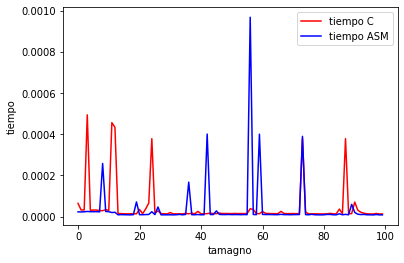

In [26]:
plt.plot(index, tcp, 'r-', label='tiempo C')
plt.plot(index, tasmp, 'b-', label='tiempo ASM')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.show()

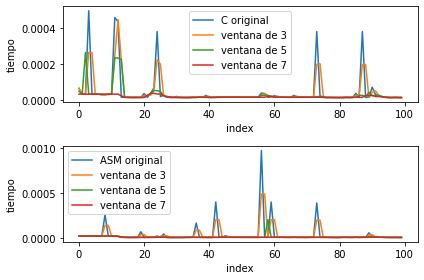

In [27]:
# gráficos de los mediciones sin ruido para distintos tamagno de ventana
# primero los tiempos de C
plt.subplot(2,1,1)
plt.plot(index, tcp, label='C original')
plt.plot(index, filtro_mediana(tcp,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tcp,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tcp,7), label='ventana de 7')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
# luego los tiempos de ASM
plt.subplot(2,1,2)
plt.plot(index, tasmp, label='ASM original')
plt.plot(index, filtro_mediana(tasmp,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tasmp,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tasmp,7), label='ventana de 7')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
# para evitar que los gráficos estén muy pegados
plt.tight_layout()

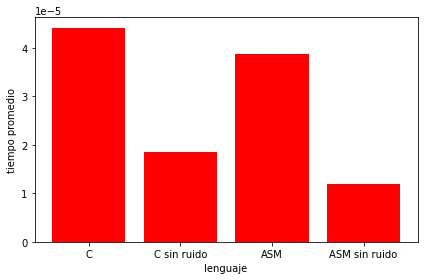

In [28]:
# para comparar el promedio con ruido y sin ruido en el caso pequeño de la función en C y ASM
noms = ['C','C sin ruido','ASM','ASM sin ruido']
proms = [ 
    statistics.mean(tcp), 
    statistics.mean(filtro_mediana(tcp,7)),
    statistics.mean(tasmp), 
    statistics.mean(filtro_mediana(tasmp,7))
]
plt.bar(noms,proms,color='r')
plt.xlabel('lenguaje')
plt.ylabel('tiempo promedio')
plt.tight_layout()

In [29]:
# luego el caso más grande
veces = 100
tam = sizes[-1]
index = range(veces)
tcg = []
tasmg = []

for i in range(veces):
    # entradas
    xg = numpy.random.rand(tam,1).astype(numpy.float32)
    yg = numpy.random.rand(tam,1).astype(numpy.float32)
    
    # salidas
    zg =  numpy.zeros((tam,1),dtype=numpy.float32)
    
    # tiempo C
    t = time.time()
    cvfadd(xg,yg,zg,tam)
    tcg.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    cvfaddasm(xg,yg,zg,tam)
    tasmg.append(time.time() - t)

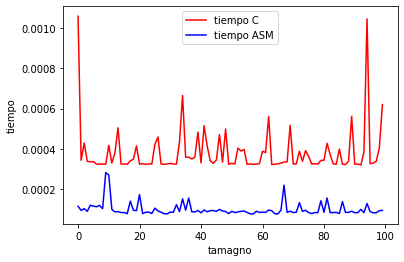

In [30]:
plt.plot(index, tcg, 'r-', label='tiempo C')
plt.plot(index, tasmg, 'b-', label='tiempo ASM')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.show()

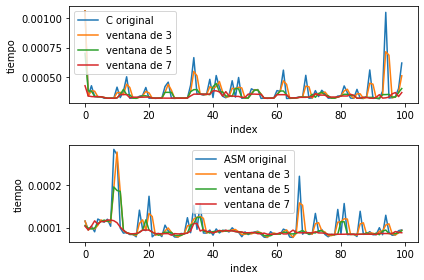

In [31]:
# gráficos de los mediciones sin ruido para distintos tamagno de ventana
# primero los tiempos de C
plt.subplot(2,1,1)
plt.plot(index, tcg, label='C original')
plt.plot(index, filtro_mediana(tcg,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tcg,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tcg,7), label='ventana de 7')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
# luego los tiempos de ASM
plt.subplot(2,1,2)
plt.plot(index, tasmg, label='ASM original')
plt.plot(index, filtro_mediana(tasmg,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tasmg,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tasmg,7), label='ventana de 7')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
# para evitar que los gráficos estén muy pegados
plt.tight_layout()

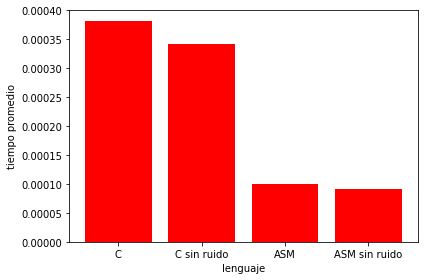

In [32]:
# para comparar el promedio con ruido y sin ruido en el caso grande de la función en C y ASM

noms = ['C','C sin ruido','ASM','ASM sin ruido']
proms = [ 
    statistics.mean(tcg), 
    statistics.mean(filtro_mediana(tcg,7)),
    statistics.mean(tasmg), 
    statistics.mean(filtro_mediana(tasmg,7))
]
plt.bar(noms,proms,color='r')
plt.xlabel('lenguaje')
plt.ylabel('tiempo promedio')
plt.tight_layout()

In [33]:
# aparentemente el ruido distorsiona el promedio en casos de menor tamagno
# en casos grandes la contribución del ruido no se percibe
# sin embargo, se obtará por filtrar todas las mediciones para poder promediar
# se coge el tamagno 7 de ventana porque parece ser el tamagno ideal
# caso general

tci = []
tasmi = []

for i, size in enumerate(sizes):
    tci = []
    tasmi = []
    for j in range(veces):
        # entradas
        x = numpy.random.rand(size,1).astype(numpy.float32)
        y = numpy.random.rand(size,1).astype(numpy.float32)
    
        # salidas
        zl =  numpy.zeros((size,1),dtype=numpy.float32)
        zn =  numpy.zeros((size,1),dtype=numpy.float32)
    
        # tiempo C
        t = time.time()
        cvfadd(x,y,zl,size)
        tci.append(time.time() - t)
    
        # tiempo ASM
        t = time.time()
        cvfaddasm(x,y,zl,size)
        tasmi.append(time.time() - t)
        
    tc[i] = statistics.mean(filtro_mediana(tci,7))
    tasm[i] = statistics.mean(filtro_mediana(tasmi,7))

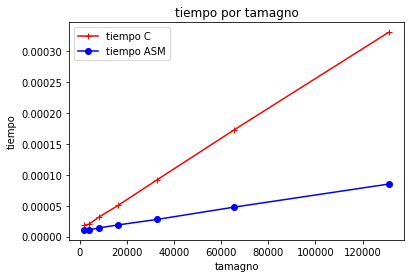

In [34]:
plt.plot(sizes, tc, 'r-+', label='tiempo C')
plt.plot(sizes, tasm, 'b-o', label='tiempo ASM')
plt.title('tiempo por tamagno')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.show()

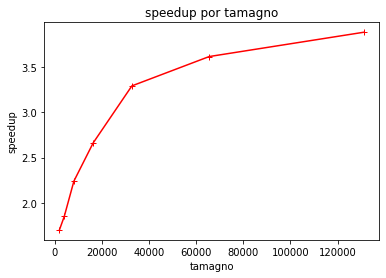

In [35]:
plt.plot(sizes, tc/tasm, 'r-+')
plt.title('speedup por tamagno')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.show()

In [36]:
! rm *.o
! rm *.so
! rm *.asm
! rm *.c